In [54]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pydicom

In [55]:
study_dir = "./Sample data/HN-CHUM-001/08-27-1885-PANC. avec C.A. SPHRE ORL   tte et cou  -TP-74220/"

In [ ]:
# General functions

def load_dicom_slices(data_dir):    
    print("Loading DICOM slices ...")
    
    file_names = sorted(os.listdir(data_dir))
    dicom_files = [pydicom.dcmread(data_dir + fn) for fn in file_names]

    dicom_slices = []
    n_skipped = 0
    for f in dicom_files:
        if hasattr(f, 'SliceLocation'): # Only take the slice if slice location attribute exists
            dicom_slices.append(f)
        else:
            n_skipped += 1
    
    dicom_slices = sorted(dicom_slices, key=lambda sl: sl.SliceLocation) # Sort slices by slice location (starting from feet-side) 
    
    print("Total slices found:", len(dicom_files))
    print("Slices loaded:", len(dicom_slices))
    print("Slices skipped:", n_skipped)
    print("Pixel spacing:", dicom_slices[0].PixelSpacing)
    print("Slice thickness:", dicom_slices[0].SliceThickness)
    
    return dicom_slices, n_skipped

# CT data

In [56]:
# CT specific Functions

def get_ct_volume(dicom_slices):
    """
    Returns --
    ct_volume: Numpy array of shape (rows, columns, slices) 
    """
    ct_vol_shape = list(dicom_slices[0].pixel_array.shape)
    ct_vol_shape.append(len(dicom_slices))
    ct_volume = np.zeros(ct_vol_shape)
    
    rescale_slope = dicom_slices[0].RescaleSlope
    rescale_intercept = dicom_slices[0].RescaleIntercept
    
    for i, sl in enumerate(dicom_slices):
        image2d = sl.pixel_array
        image2d[image2d == -2000] = 0 # Set out-of-bound region values to 0 (to make it same as air) 
        image2d_hu = image2d * rescale_slope + rescale_intercept # Converting to HU
        ct_volume[:,:,i] = image2d_hu
    
    return ct_volume


def apply_hu_window(ct_volume, window_level, window_width):
    ct_volume_win = ct_volume.copy()
    
    window_max = window_level + window_width // 2
    window_min = window_level - window_width // 2

    ct_volume_win[ct_volume_win > window_max] = window_max
    ct_volume_win[ct_volume_win < window_min] = window_min
    
    return ct_volume_win

In [58]:
ct_data_dir = study_dir + "3.000000-StandardFull-07232/"

dicom_slices, n_skipped = load_dicom_slices(ct_data_dir)

ct_volume = get_ct_volume(dicom_slices)

ct_volume_win = apply_hu_window(ct_volume, 100, 300)

Loading DICOM slices ...
Total slices found: 90
Slices loaded: 90
Slices skipped: 0
Pixel spacing: [0.976562, 0.976562]
Slice thickness: 3.750000


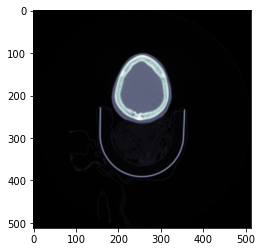

-1005.0


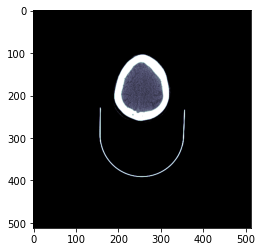

-50.0


In [59]:
plt.imshow(ct_volume[:,:,80], cmap=plt.cm.bone)
plt.show()
print(ct_volume[300,100,80])

plt.imshow(ct_volume_win[:,:,80], cmap=plt.cm.bone)
plt.show()
print(ct_volume_win[300,100,80])


# PET data

In [61]:
pet_data_dir = study_dir + "4.000000-TETECOUAC2D-27812/"

dicom_slices, n_skipped = load_dicom_slices(pet_data_dir)

Loading DICOM slices ...
Total slices found: 92
Slices loaded: 91
Slices skipped: 1
Pixel spacing: [3.515625, 3.515625]
Slice thickness: 3.2700
